In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from collections import deque
from itertools import count
from copy import deepcopy
from PIL import Image
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

# создаем энвайронмент с игрой
env = gym.make('Breakout-v0').unwrapped

# настраиваем matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display    
print("Is python : {}".format(is_ipython))

# выбираем девайс для игры
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print("Device : {}".format(device))

# запоминаем, сколько действий в игре
ACTIONS_NUM = env.action_space.n
print("Number of actions : {}".format(ACTIONS_NUM))

/home/v.shadymov/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Is python : True
Device : cuda:2
Number of actions : 4


In [3]:
STATE_SIZE = 4
STATE_W = 84
STATE_H = 84
MEMSIZE = 50000

# Задание 1. Необходимо реализовать класс для хранения состояния игры. 
class StateHolder:
    def __init__(self, capacity=STATE_SIZE):
        self.capacity = capacity
        self.state = None
        
    def reset(self):
        self.state = None
        
    def push(self, new_screen):
        new_screen = new_screen.squeeze(0)
        if self.state is None: 
            self.state = torch.cat([new_screen for i in range(self.capacity)])
        else:
            self.state = torch.cat((self.state, new_screen))[1:]
        
    def get_state(self):
        if self.state is None: return None
        else: return self.state.unsqueeze(0)
    
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:

    def __init__(self, capacity = MEMSIZE):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        #Положить переход в память
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        #Получить сэмпл из памяти
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
# Задание 2. Собрать архитектуру сети (DQN).
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=5, stride=1)
        #self.bn1 = nn.BatchNorm2d(16)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1)
        #self.bn2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=1)
        #self.bn3 = nn.BatchNorm2d(32)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        
        self.fc = nn.Linear(1568, 512)
        #self.bn4 = nn.BatchNorm1d(1)
        self.head = nn.Linear(512, ACTIONS_NUM)
        
        #self.relu = nn.ReLU()
        #self.tanh = nn.Tanh()
        #self.sigmoid = nn.Sigmoid()
        #self.elu = nn.ELU()
        self.tanhshrink = nn.Tanhshrink()

    def forward(self, x):
        x = x.to(torch.float32)
        x = self.relu(self.maxpool1(self.conv1(x)))
        x = self.relu(self.maxpool2(self.conv2(x)))
        x = self.relu(self.maxpool3(self.conv3(x)))
        x = x.view(x.size(0), -1).unsqueeze(1)
        x = self.fc(x)
        x = self.tanhshrink(x)
        return self.head(x).squeeze(1)

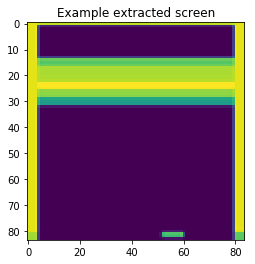

In [5]:
# Тут блок с кодом, генерирующим 1 кадр игры
resize = T.Compose([T.ToPILImage(),
                    T.Resize( (STATE_W, STATE_H), interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen():
    screen = env.render(mode='rgb_array')
    screen = np.dot(screen[...,:3], [0.299, 0.587, 0.114])
    screen = screen[30:195,:]
    screen = np.ascontiguousarray(screen, dtype=np.uint8).reshape(screen.shape[0],screen.shape[1],1)
    return resize(screen).mul(255).type(torch.ByteTensor).to(device).detach().unsqueeze(0)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().reshape(-1,84).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [6]:
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)

memory = ReplayMemory()
state_holder = StateHolder()

def select_action(state, eps_threshold):
    global steps_done
    sample = random.random()
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(ACTIONS_NUM)]], device=device, dtype=torch.long)

train_rewards = []

mean_size = 100
mean_step = 1

def plot_rewards(rewards = train_rewards, name = "Train"):
    plt.figure(2)
    plt.clf()
    plt.title(name)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(rewards)
    # Строим график среднего вознаграждения по 100 последним эпизодам
    if len(rewards) > mean_size:
        means = np.array([rewards[i:i+mean_size:] for i in range(0, len(rewards) - mean_size, mean_step)]).mean(1)
        means = np.concatenate((np.zeros(mean_size - 1), means))
        plt.plot(means)

In [7]:
BATCH_SIZE = 32
GAMMA = 0.99

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    # выбираем новый батч
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    # Для всех состояний считаем маску не финальнсти и конкантенируем их
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)

    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Считаем Q(s_t, a) - модель дает Q(s_t), затем мы выбираем
    # колонки, которые соответствуют нашим действиям на щаге
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Подсчитываем ценность состяония V(s_{t+1}) для всех последующмх состояний.
    next_state_values = torch.zeros(BATCH_SIZE, device=device).detach()
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach() # берем значение максимума
    
    # Считаем ожидаемое значение функции оценки ценности действия  Q-values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Считаем ошибку Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Оптимизация модели
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    del non_final_mask
    del non_final_next_states
    del state_batch
    del action_batch
    del reward_batch
    del state_action_values
    del next_state_values
    del expected_state_action_values
    del loss

Episode score : 1.0
Mean score : 1.01
eps_threshold: 0.999772328801621
Episode score : 0.0
Mean score : 1.01
eps_threshold: 0.9996184808877675
Episode score : 5.0
Mean score : 1.04
eps_threshold: 0.9992020539413936
Episode score : 4.0
Mean score : 1.07
eps_threshold: 0.9988640175239406
Episode score : 0.0
Mean score : 1.06
eps_threshold: 0.9987085274991839
Episode score : 2.0
Mean score : 1.08
eps_threshold: 0.9984380569402679
Episode score : 0.0
Mean score : 1.08
eps_threshold: 0.9982790474769421
Episode score : 1.0
Mean score : 1.09
eps_threshold: 0.9980904286826384
Episode score : 1.0
Mean score : 1.1
eps_threshold: 0.997877606471469
Episode score : 0.0
Mean score : 1.1
eps_threshold: 0.9977267757037209
Episode score : 3.0
Mean score : 1.12
eps_threshold: 0.9974099340777347
Episode score : 3.0
Mean score : 1.12
eps_threshold: 0.9971156318875548
Episode score : 3.0
Mean score : 1.12
eps_threshold: 0.9968250135055434
Episode score : 1.0
Mean score : 1.12
eps_threshold: 0.9966160776193

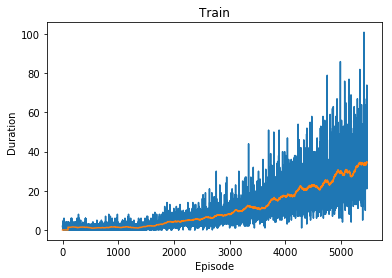

In [9]:
# количество эпизодов, которые играем
NUM_EPISODES = 100000 

# количество кадров, между которыми обучаем модель
OPTIMIZE_MODEL_STEP = 5
# количество кадров, между которыми обновляем target-модель
TARGET_UPDATE = 10000 

# несколько шагов для разогрева модели()
STEPS_BEFORE_TRAIN = 50000 

# параметры для e-greedy стратегии выбора действия
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 1000000 #10^6

policy_net.train()
target_net.eval()

state_holder = StateHolder()
test_rewards = []

# Общее число 
steps_done = 0

# Задание 3. Заполнить пропуски в нижеприведенном коде.

for iter in tqdm_notebook(range(NUM_EPISODES)):
    
    # Инициализации разлинычх переменных
    # env - среды
    # state_holder - хранителя состояния
    # lives - количества жизней в начале эпизода игры
    env.reset()
    state_holder.push(get_screen())
    state = state_holder.get_state()
    lives_counter = env.ale.lives()
    ep_rewards = []
    
    for t in count():
        
        # Рассчет eps_threshold'а для e-greedy
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.*steps_done/EPS_DECAY)
            
        action = select_action(state, eps_threshold)
        # Шаг одного кадра игры 
        _, reward, done, _ = env.step(action.item())
        # где:
        # reward - награда, полученная в рамках последнего действия
        # done - флаг окончания эпизода
        ep_rewards.append(reward)
        reward = torch.tensor([reward], device=device)
        
        
        # Работа с ReplayMemory
        state_holder.push(get_screen()) #обновляем держатель состояний после действия
        
        if done:
            next_state = None
            memory.push(state, action, next_state, reward)
        elif lives_counter>env.ale.lives():
            lives_counter = env.ale.lives()
            next_state = None
            memory.push(state, action, next_state, reward)
            state = state_holder.get_state()
        else:
            next_state = state_holder.get_state()
            memory.push(state, action, next_state, reward)
            state = next_state
        
        
        # Шаг оптимизации
        if (steps_done > STEPS_BEFORE_TRAIN) and steps_done % OPTIMIZE_MODEL_STEP == 0:
            optimize_model()
        
        # Шаг обновления target'сети
        if steps_done % TARGET_UPDATE == 0:
            print("Target net updated!")
            target_net.load_state_dict(policy_net.state_dict())
        
        # Код завершающий эпизод игры/обучения
        if done:
            train_rewards.append(np.sum(ep_rewards))
            # Суммарный reward(не дисконтированный) за последний эпизод
            print("Episode score : {}".format(train_rewards[-1]))
            # Средний reward по последним 100 эпизодам
            print("Mean score : {}".format(np.mean(train_rewards[-100:])))
            print("eps_threshold:", eps_threshold)
            
            plot_rewards()
            break 
    if np.mean(train_rewards[-100:]) > 35:
        break

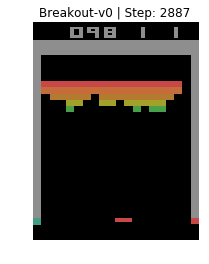

Total game reward : 98.0


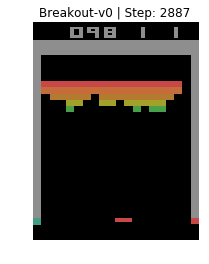

In [11]:
# Тут код для тестирования.
print(eps_threshold)

TEST_EPS = 0.05

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())


policy_net.eval()
env.reset()
state_holder.reset()
    
state_holder.push(get_screen())

total_reward = 0

for i in count():
    # Выбрать и выполнить нове действие
    action = select_action(state_holder.get_state().to(torch.float32), TEST_EPS)
    _, reward, done, _ = env.step(action.item())
    total_reward += reward
    # Получаем новое состояние
    if not done:
        state_holder.push(get_screen())
    else:
        break
    show_state(env, i)
    
print("Total game reward : {}".format(total_reward))